# Job Analysis

1. Data Cleaning
2. EDA
3. Modeling


In [668]:
import pandas as pd
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt

In [669]:
df = pd.read_csv('glassdoor_jobs.csv')

In [670]:
df.head()



,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa..."
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee"


## Data Cleaning

#### 1) Salary Cleaning

In [671]:
df['salary'] = df['Salary Estimate'].apply(lambda x: x.split('(')[0].strip())
df['hourly'] = df['salary'].apply(lambda x: 1 if 'hour' in x.lower() else 0)
df['salary'] = df['salary'].apply(lambda x: x.replace('$',"").replace('K',"").replace('Employer Provided Salary:',"").replace("Per Hour",""))
df = df[df['salary']!= '-1']
df['min_salary'] = df['salary'].apply(lambda x: int(x.split('-')[0].strip()))
df['max_salary'] = df['salary'].apply(lambda x: int(x.split('-')[1].strip()))

df['min_salary'] = df.apply(lambda x: x.min_salary*52*40 if x.hourly == 1 else x.min_salary, axis =1)
df['max_salary'] = df.apply(lambda x: x.max_salary*52*40 if x.hourly == 1 else x.max_salary, axis =1)
df['avg_salary'] = (df['min_salary'] + df['max_salary'])/2


#### 2) Job Title Cleaning

In [672]:
def job_cate(x):
    x = x.lower()
    if "data scientist" in x:
        return "Data Scientist"
    elif "data engineer" in x:
        return "Data Engineer"
    elif "analyst" in x:
        return "Data Analyst"
    elif "machine learning" in x:
        return "Machine learning engineer"
    elif "scientist" in x:
        return "Scientist"
    else:
        return "NA"
def seniority(x):
    x = x.lower()
    high = ['lead', 'director', 'manager', 'officer']
    seniors = ['senior', 'sr', 'sr.']
    for high_ele in high:
        if high_ele in x:
            return "director"
    
    for senior in seniors:
        if senior in x:
            return "senior"
    return "NA"


df['Job_Category'] = df['Job Title'].apply(job_cate)
df['seniority'] = df['Job Title'].apply(seniority)


#### 3) State, age_of_company, num_competitors, hq


In [673]:
df["state"] = df["Location"].apply(lambda x: x.split(",")[1].strip() if len(x.split(",")) == 2 else x)
wrong_str = {"United States": "NA","New Jersey" : "NJ", "Utah" : "UT","Texas" :  "TX", "Patuxent, Anne Arundel, MD" : "MD","California" : "CA"}
df["state"] = df["state"].apply(lambda x: wrong_str[x] if x in wrong_str else x)
df.columns
df["num_competitors"] = df["Competitors"].apply(lambda x: 0 if x == '-1' else x)
df["num_competitors"] = df["num_competitors"].apply(lambda x: len(x.split(',')) if isinstance(x,str) else x)
df["num_competitors"].value_counts()
df["age_of_company"] = df["Founded"].apply(lambda x: 2022-x if x>0 else x)
df["Hq"] = df.apply(lambda x: 1 if x.Location == x.Headquarters else 0, axis = 1)


In [674]:
df.columns

Index(['Unnamed: 0', 'Job Title', 'Salary Estimate', 'Job Description',
       'Rating', 'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'salary', 'hourly', 'min_salary', 'max_salary', 'avg_salary',
       'Job_Category', 'seniority', 'state', 'num_competitors',
       'age_of_company', 'Hq'],
      dtype='object')

#### 4) Job Description, Company Name Cleaning


In [675]:

df["Company Name"] = df["Company Name"].apply(lambda x : x.split("\n")[0] ) 
df["Job Description"] = df["Job Description"].apply(lambda x : x.replace("\n", " ") )

#### 5) Size, Revenue

In [676]:
def size_cleaning(x):
    if x == "-1" or x == "Unknown":
        x = "NA" 
    elif "10000+" in x:
        x = 10000
    else:
        x = int((int(x.split(" to ")[0]) + int(x.split(" to ")[1].split()[0]) )/2)
    return x
df["company_size"] = df["Size"].apply(size_cleaning)
df["company_size"]

def revenue_cleaning(x):
    if x == "-1" or x =='Unknown / Non-Applicable' :
        x = "NA"
    elif "$10+ billion" in x:
        x = 10 * 1000
    elif "Less than $1 million" in x:
        x = 1
    elif "$500 million to $1 billion" in x:
        x = 750
    elif  "billion" in x:
        x = (int(x.replace("$", "").split(" ")[0]) + int(x.replace("$", "").split(" to ")[1].split(" ")[0]) )/ 2 * 1000
    elif "million" in x:
        x = (int(x.replace("$", "").split(" ")[0]) + int(x.replace("$", "").split(" to ")[1].split(" ")[0]) )/ 2
    return x

df["Rev_million"] = df["Revenue"].apply(revenue_cleaning)
df["Rev_million"].value_counts()

NA        204
10000     124
300.0      91
1500.0     60
750        57
75.0       46
37.5       40
3500.0     39
17.5       32
7500.0     19
7.5        18
3.0         8
1           4
Name: Rev_million, dtype: int64

#### 6) Keyword selection from job description, length of description


In [677]:
# we would like to extract few key words that I believe is critical to data scientist role
word_list = ["python","r studio","excel","sql","gcp","aws"]
for word in word_list:
    df[word] = df["Job Description"].apply(lambda x: 1 if word in x.lower() else 0)

df['desc_len'] = df["Job Description"].apply(lambda x: len(x))

In [678]:
# Let's make a dataframe with the columns that we only need
df.columns
df = df[['Job Title', 'Job_Category','seniority', 'Job Description', 'Rating',
       'Company Name', 'state' , 'company_size', 'Sector', 'Type of ownership', 'Rev_million','num_competitors',
       'avg_salary', 'age_of_company',"python","r studio","excel","sql","gcp","aws",'desc_len',"Hq"]]


## EDA

There are two parts in this analysis.

1) Understand the columns itself
    - qunatative columns analysis
    - correlation of quantative columns
    

2) See the relationship between columns using pivot table


In [679]:
df.describe()

,Rating,num_competitors,avg_salary,age_of_company,python,r studio,excel,sql,gcp,aws,desc_len,Hq
count,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,3.618868,1.053908,1781.758086,48.456873,0.528302,0.001348,0.522911,0.512129,0.043127,0.237197,3869.545822,0.557951
std,0.801210,1.384239,9405.509823,53.900445,0.499535,0.036711,0.499812,0.500190,0.203279,0.425651,1521.495868,0.496965
min,-1.000000,0.000000,15.500000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000
25%,3.300000,0.000000,77.125000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2801.000000,0.000000
50%,3.700000,0.000000,100.000000,26.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3731.000000,1.000000
75%,4.000000,3.000000,128.500000,61.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,4740.000000,1.000000
max,5.000000,4.000000,76960.000000,278.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10051.000000,1.000000


Now let's understand quantitative columns with the corresponding histogram

array([[<AxesSubplot:title={'center':'Rating'}>,
        <AxesSubplot:title={'center':'num_competitors'}>,
        <AxesSubplot:title={'center':'avg_salary'}>],
       [<AxesSubplot:title={'center':'age_of_company'}>,
        <AxesSubplot:title={'center':'python'}>,
        <AxesSubplot:title={'center':'r studio'}>],
       [<AxesSubplot:title={'center':'excel'}>,
        <AxesSubplot:title={'center':'sql'}>,
        <AxesSubplot:title={'center':'gcp'}>],
       [<AxesSubplot:title={'center':'aws'}>,
        <AxesSubplot:title={'center':'desc_len'}>,
        <AxesSubplot:title={'center':'Hq'}>]], dtype=object)

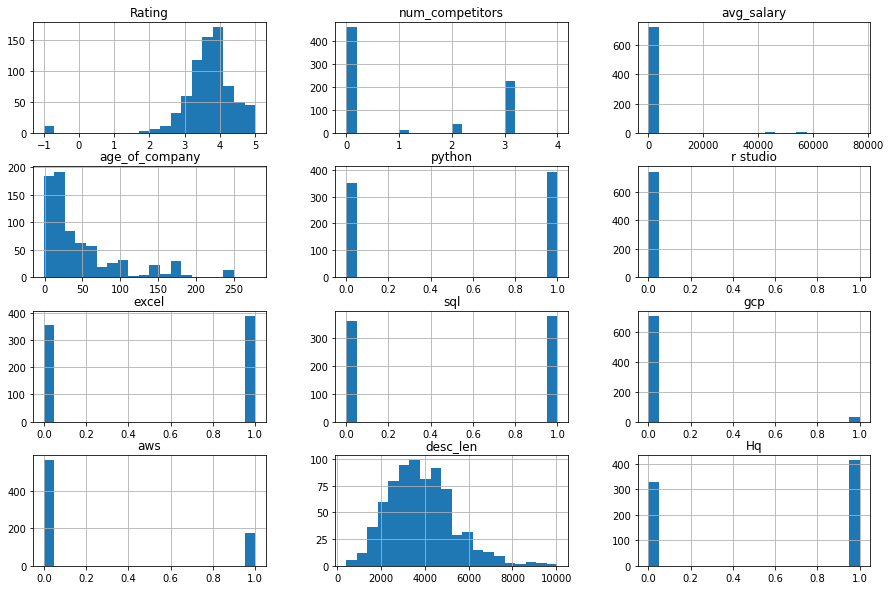

In [680]:
df.hist(bins = 20, figsize = (15,10))

                   Rating  num_competitors  avg_salary  age_of_company  \
Rating           1.000000         0.027190   -0.011940        0.024665   
num_competitors  0.027190         1.000000   -0.114332        0.128272   
avg_salary      -0.011940        -0.114332    1.000000        0.014231   
age_of_company   0.024665         0.128272    0.014231        1.000000   
python           0.144665         0.091470   -0.187933       -0.098092   
r studio        -0.023806         0.051682   -0.006602       -0.015998   
excel           -0.036466        -0.031046   -0.101844        0.038659   
sql              0.134463         0.061426   -0.183151       -0.117662   
gcp              0.072885        -0.065825    0.016296       -0.072129   
aws              0.117049        -0.014860   -0.038760       -0.033141   
desc_len        -0.012281         0.104620   -0.091659        0.164461   
Hq               0.085033        -0.102635   -0.041422       -0.164903   

                   python  r studio  

<AxesSubplot:>

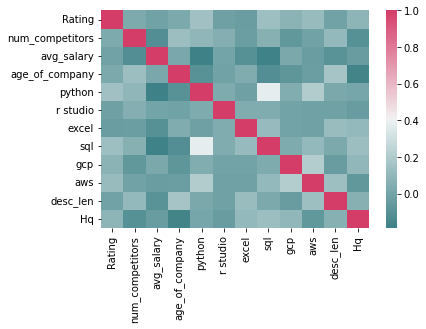

In [681]:
print(df.corr())
cmap = sns.diverging_palette(200, 0, as_cmap = True)
sns.heatmap(df.corr(), cmap = cmap)

Let's do analysis for categorical variabales

/var/folders/ph/yfqxnlss1ds28x8n8wzmqfg00000gn/T/ipykernel_11285/4116102487.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


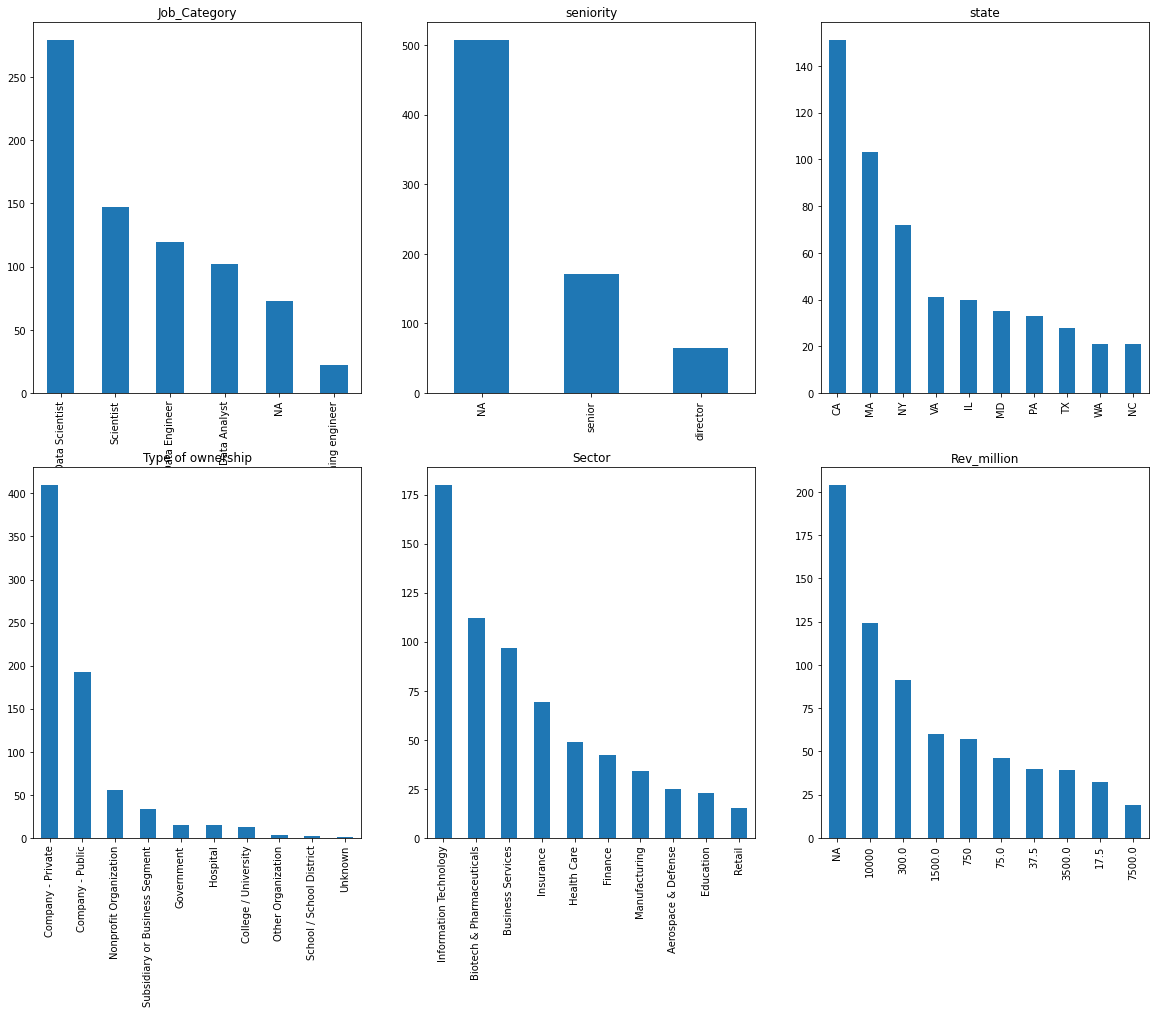

In [682]:
categorical_features = ["Job_Category", "seniority", "state", "Type of ownership","Sector", "Rev_million"]
fig, ax = plt.subplots(2, 3, figsize = (20,15))
#fig.tight_layout()
axe = ax.ravel()

for i, categorical_feature in enumerate(df[categorical_features]):
    df[categorical_feature].value_counts().head(10).plot(kind = "bar", ax=axe[i]).set_title(categorical_feature)
fig.show()

In [683]:
# Alternatively we can plot one columns after another using the below method
# for i in df[categorical_features].columns:
#     cat_num = df[categorical_features][i].value_counts()
#     chart = sns.barplot(x = cat_num.index, y = cat_num)
#     chart.set_xticklabels(chart.get_xticklabels(), rotation = 90)
#     plt.show()



Now let's see the relationships btw variables and avg_salary

In [684]:
df["count"] = 1
df.columns
pivot_columns = ['Job_Category', 'Rating',
       'Company Name', 'state', 'company_size', 'Sector', 'Type of ownership',
       'Rev_million', 'num_competitors', 'avg_salary', 'age_of_company',
       'python', 'r studio', 'excel', 'sql', 'gcp', 'aws', "count"]
for column in pivot_columns:
    if column != "avg_salary" and column != "count":
        print(column)
        print(pd.pivot_table(df, index = column, values = ['avg_salary', 'count'], aggfunc= {'avg_salary' : np.mean, "count" : len}).sort_values('avg_salary', ascending= False).to_string())

Job_Category
                            avg_salary  count
Job_Category                                 
Scientist                  8189.105442    147
Data Analyst                616.181373    102
Machine learning engineer   126.431818     22
Data Scientist              117.564516    279
Data Engineer               105.403361    119
NA                           99.869863     73
Rating
         avg_salary  count
Rating                    
 3.6    9395.771739     46
 3.3    4339.820513     39
 2.7    4092.750000     14
 4.0    3909.468085     47
 3.7    3324.877049     61
 3.2    3075.500000     35
 3.8    1357.844262     61
 3.4    1038.011364     44
-1.0     136.181818     11
 5.0     134.700000      5
 2.5     120.000000      2
 4.5     117.714286      7
 4.1     116.368421     19
 3.9     113.071429     63
 2.6     109.083333     12
 4.4     108.606061     33
 3.5     104.897959     49
 4.7     103.983871     31
 4.3     102.468750     32
 4.2     100.442308     26
 2.2      97.75000

## Model Building

In [685]:
import sklearn

In [686]:
# let's pull out only the columns that we can use for the multilinear regression
df.columns

for column in list(df.columns):
    if column != "Job Description":
        print(df[column].value_counts())

# go thorough the values for each columns for the last time
df.drop('count', axis = 1)

# there are queit large portion of NA and -1. However, let's try to consider them as a value itself and build a model.



Data Scientist                     131
Data Engineer                       53
Senior Data Scientist               34
Data Analyst                        15
Senior Data Engineer                14
                                  ... 
Data Scientist/ML Engineer           1
Sr. Data Scientist                   1
Data Engineer 4 - Contract           1
Data Analyst - Asset Management      1
Machine Learning Engineer (NLP)      1
Name: Job Title, Length: 264, dtype: int64
Data Scientist               279
Scientist                    147
Data Engineer                119
Data Analyst                 102
NA                            73
Machine learning engineer     22
Name: Job_Category, dtype: int64
NA          507
senior      171
director     64
Name: seniority, dtype: int64
 3.9    63
 3.8    61
 3.7    61
 3.5    49
 4.0    47
 3.6    46
 3.4    44
 3.3    39
 3.2    35
 4.4    33
 4.3    32
 4.7    31
 4.2    26
 3.1    25
 4.1    19
 2.9    18
 3.0    17
 2.7    14
 2.6    12
-1.0    11

,Job Title,Job_Category,seniority,Job Description,Rating,Company Name,state,company_size,Sector,Type of ownership,...,avg_salary,age_of_company,python,r studio,excel,sql,gcp,aws,desc_len,Hq
0,Data Scientist,Data Scientist,NA,"Data Scientist Location: Albuquerque, NM Educa...",3.8,Tecolote Research,NM,750,Aerospace & Defense,Company - Private,...,72.0,49,1,0,1,0,0,0,2536,0
1,Healthcare Data Scientist,Data Scientist,NA,What You Will Do: I. General Summary The Hea...,3.4,University of Maryland Medical System,MD,10000,Health Care,Other Organization,...,87.5,38,1,0,0,0,0,0,4783,0
2,Data Scientist,Data Scientist,NA,"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4,FL,750,Business Services,Company - Private,...,85.0,12,1,0,1,1,0,0,3461,1
3,Data Scientist,Data Scientist,NA,*Organization and Job ID** Job ID: 310709 Dir...,3.8,PNNL,WA,3000,"Oil, Gas, Energy & Utilities",Government,...,76.5,57,1,0,0,0,0,0,3883,1
4,Data Scientist,Data Scientist,NA,Data Scientist Affinity Solutions / Marketing ...,2.9,Affinity Solutions,NY,125,Business Services,Company - Private,...,114.5,24,1,0,1,1,0,0,2728,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,"Sr Scientist, Immuno-Oncology - Oncology",Scientist,senior,Site Name: USA - Massachusetts - Cambridge Pos...,3.9,GSK,MA,10000,Biotech & Pharmaceuticals,Company - Public,...,84.5,192,0,0,0,0,0,1,6162,0
951,Senior Data Engineer,Data Engineer,senior,THE CHALLENGE Eventbrite has a world-class dat...,4.4,Eventbrite,TN,3000,Information Technology,Company - Public,...,102.5,16,1,0,0,1,0,1,6130,0
952,"Project Scientist - Auton Lab, Robotics Institute",Scientist,NA,The Auton Lab at Carnegie Mellon University is...,2.6,Software Engineering Institute,PA,750,Education,College / University,...,73.5,38,0,0,1,0,0,0,3078,1
953,Data Science Manager,NA,director,Data Science ManagerResponsibilities: Oversee...,3.2,"Numeric, LLC",PA,25,Business Services,Company - Private,...,127.5,-1,0,0,1,0,0,0,1642,0


In [687]:
# choose relevant columns
df.columns
df_models  = df[['avg_salary','Job_Category', 'seniority', 'Rating',
    'state', 'company_size', 'Sector', 'Type of ownership',
       'Rev_million', 'num_competitors',  'age_of_company',
       'python', 'excel', 'sql', 'gcp', 'aws','desc_len','Hq']]

df_models['avg_salary']
# # Job_Category / NA -> Mode
# df_models["Job_Category"] = df_models["Job_Category"].apply(lambda x: "Data Scientist" if x == "NA" else x)

# # Rating / -1 -> mode

# count = 0
# result = 0
# for val in df_models["Rating"]:
#     if val != -1:
#         count +=1
#         result += val
# result = result / count
# df_models["Rating"] = df_models["Rating"].apply(lambda x: result if x == -1 else x)


# # company_size / NA -> mode

# count = 0
# result = 0
# for val in df_models["company_size"]:
#     if val != "NA":
#         count +=1
#         result += val
# result = result / count
# df_models["company_size"] = df_models["company_size"].apply(lambda x: result if x == "NA" else x)

# # Sector -1. -> mode
# df_models["Sector"] = df_models["Sector"].apply(lambda x: df.mode().iloc[0]["Sector"] if x == "-1" else x)

# # Type of ownership -1 -> mode

# df_models["Type of ownership"] = df_models["Type of ownership"].apply(lambda x: df.mode().iloc[0]["Type of ownership"] if x == "-1" else x)

# # Rev_million NA -> Mode (*****)
# count = 0
# result = 0
# for val in df_models["Rev_million"]:
#     if val != "NA":
#         count +=1
#         result += val
# result = result / count
# df_models["Rev_million"] = df_models["Rev_million"].apply(lambda x: result if x == "NA" else x)


# # age_of_company -1 -> Mode (********)
# count = 0
# result = 0
# for val in df_models["age_of_company"]:
#     if val != -1:
#         count +=1
#         result += val
# result = result / count
# df_models["age_of_company"] = df_models["age_of_company"].apply(lambda x: result if x == -1 else x)


/var/folders/ph/yfqxnlss1ds28x8n8wzmqfg00000gn/T/ipykernel_11285/2271457738.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_models["Job_Category"] = df_models["Job_Category"].apply(lambda x: "Data Scientist" if x == "NA" else x)
/var/folders/ph/yfqxnlss1ds28x8n8wzmqfg00000gn/T/ipykernel_11285/2271457738.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_models["Rating"] = df_models["Rating"].apply(lambda x: result if x == -1 else x)
/var/folders/ph/yfqxnlss1ds28x8n8wzmqfg00000gn/T/ipykernel_112

In [688]:
# get dummy data
df_dum = pd.get_dummies(df_models)
df_dum.shape
# for i in df_dum.columns:
#     print(i)

(742, 93)

In [689]:
# train test split
from sklearn.model_selection import train_test_split
X = df_dum.drop("avg_salary", axis = 1)
y = df_dum["avg_salary"] # make sure to return array instead of series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [690]:
# multiple linear regression
import statsmodels.api as sm 
X_sm = sm.add_constant(X)
model = sm.OLS(y,X_sm)
model.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_salary   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     14.68
Date:                Mon, 14 Feb 2022   Prob (F-statistic):          4.93e-106
Time:                        21:12:23   Log-Likelihood:                -7439.2
No. Observations:                 742   AIC:                         1.505e+04
Df Residuals:                     654   BIC:                         1.546e+04
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                             3058.5687   1364.001      2.242      0.025     380.219    5736.918
Rating                                             763.0024    485.170      1.573      0.116    -189.676    1715.681
company_size                                        -0.0765      0.125     -0.610      0.542      -0.323       0.170
Rev_million                                          0.1839      0.127      1.447      0.148      -0.066       0.433
num_competitors                                   -227.6300    187.575     -1.214      0.225    -595.952     140.692
age_of_company                                     -10.8097      6.422     -1.683      0.093     -23.421       1.801
python                                              62.0047    578.005      0.107      0.915   -1072.964    1196.974
excel                                               -7.8477    500.321     -0.016      0.987    -990.276     974.581
sql                                               -480.8931    586.095     -0.821      0.412   -1631.748     669.962
gcp                                              -2182.4429   1310.930     -1.665      0.096   -4756.583     391.697
aws                                                580.9757    602.487      0.964      0.335    -602.067    1764.019
desc_len                                            -0.1702      0.173     -0.986      0.325      -0.509       0.169
Hq                                                -985.0510    552.718     -1.782      0.075   -2070.366     100.264
Job_Category_Data Analyst                         1092.6169    769.457      1.420      0.156    -418.288    2603.521
Job_Category_Data Engineer                       -1210.8572    711.607     -1.702      0.089   -2608.167     186.453
Job_Category_Data Scientist                       -331.3537    604.069     -0.549      0.584   -1517.502     854.795
Job_Category_Machine learning engineer             657.0802   1321.663      0.497      0.619   -1938.134    3252.295
Job_Category_Scientist                            2851.0824    782.297      3.645      0.000    1314.966    4387.199
seniority_NA                                      1278.4844    517.334      2.471      0.014     262.648    2294.321
seniority_director                                1147.3023    797.209      1.439      0.151    -418.095    2712.700
seniority_senior                                   632.7819    625.314      1.012      0.312    -595.083    1860.647
state_AL                                         -2923.1993   2508.564     -1.165      0.244   -7849.011    2002.612
state_AZ                                         -3318.7169   2043.067     -1.624      0.105   -7330.479     693.045
state_CA                                 

In [691]:
# LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lm = LinearRegression()
# lm.fit(X_train, y_train)

cross_val_score(lm, X_train, y_train, scoring = 'neg_mean_absolute_error', cv =5)
np.mean(cross_val_score(lm, X_train, y_train, scoring = 'neg_mean_absolute_error', cv =5))


-2966.9743214666455

In [692]:
# lasso regression

In [693]:
# random forest (gradient boosted tree, support vector regression can be also used)

In [694]:
# tune model for gridsearchCV

In [695]:
# test emsambles